<a href="https://colab.research.google.com/github/Valendrew/master-nlp-assignments/blob/main/master_nlp_ass01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import dependencies

In [ ]:
!pip install tensorflow_addons --quiet

     |████████████████████████████████| 1.1 MB 15.1 MB/s 


Load dependencies required

In [127]:
from dataclasses import dataclass
import os
import os.path
import re
import shutil
import typing
import urllib.request

import keras
import keras.layers
import keras.losses
import keras.optimizers
import keras.regularizers
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm

# Dataset

## Download the data

- Download the dataset
- Unzip the dataset in the local path

In [2]:
file_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
zip_name = os.path.join(os.getcwd(), "dependency_treebank.zip")
file_name = os.path.join(os.getcwd(), "dependency_treebank")

if not os.path.isdir(file_name):
    if not os.path.isfile(zip_name):
        with urllib.request.urlopen(file_url) as res, open(zip_name, "wb") as f:
            shutil.copyfileobj(res, f)
    shutil.unpack_archive(zip_name, os.getcwd())

## Load the data

- Read the data for training (1-100), validation (101-150) and test (151-199)

In [3]:
class DataLoader:
    PUNCTUATIONS = r"[\.,\\\"'\-\?\:\!;\[\]\(\)\{\}⟨⟩‒–—―‐…\/⁄‘’“”`]+"

    def __init__(self):
        self.prog = re.compile(self.PUNCTUATIONS)

    def __call__(self, start_i: int, end_i: int, desc: typing.Optional[str] = None):
        df = pd.DataFrame(columns=["text", "tags"])
        # df_y = pd.DataFrame()

        for i in tqdm.trange(start_i, end_i+1, desc=f"Reading {desc} data"):
            idx_len = "0" * (3 - len(str(i)))
            data_file = os.path.join(file_name, f"wsj_0{idx_len}{i}.dp")
            with open(data_file, "r") as f:
                content = [l.strip().split() for l in f.readlines()]
            
            Xrows, yrows = [""], [""]
            i = 0
            for c in content:
                # New line encountered, split the following lines in a new sentence
                if len(c) == 0:
                    i += 1
                    Xrows.append("")
                    yrows.append("")
                    continue
                # Process sentence
                assert len(c) == 3
                if self.prog.fullmatch(c[1]) is None:
                    Xrows[i] += (" " if len(Xrows[i]) > 0 else "") +  c[0]
                    yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]

            new_df = pd.DataFrame.from_dict({"text": Xrows, "tags": yrows})
            df = pd.concat([df, new_df], axis=0, ignore_index=True)
        return df

data_loader = DataLoader()
df_train = data_loader(1, 100, desc="train")
df_val = data_loader(101, 150, desc="validation")
df_test = data_loader(151, 199, desc="test")

Reading test data: 100%|██████████| 49/49 [00:00<00:00, 521.00it/s]


## Closer look at datasets

In [4]:
df_train.head()

,text,tags
0,Pierre Vinken 61 years old will join the board...,NNP NNP CD NNS JJ MD VB DT NN IN DT JJ NN NNP CD
1,Mr. Vinken is chairman of Elsevier N.V. the Du...,NNP NNP VBZ NN IN NNP NNP DT NNP VBG NN
2,Rudolph Agnew 55 years old and former chairman...,NNP NNP CD NNS JJ CC JJ NN IN NNP NNP NNP NNP ...
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...
4,The asbestos fiber crocidolite is unusually re...,DT NN NN NN VBZ RB JJ IN PRP VBZ DT NNS IN RB ...


## TODO
- Distribution of classes
- Sentences length
    - Split sentences too long

# Model

In [5]:
EMBEDDING_DIM = 300
MAX_SEQUENCE = 64
VOCABULARY_SIZE = 10000

## Dataframe to dataset

In [119]:
def df_to_dataset(df: pd.DataFrame, batch_size: int = 32):
    df = df.copy()
    return tf.data.Dataset.from_tensor_slices((df["text"], df["tags"])).batch(batch_size)

raw_train_ds = df_to_dataset(df_train, 32)
raw_val_ds = df_to_dataset(df_val, 256)

## Tokenization

### Encode features

In [120]:
class TokenizeFeatures:
    vocab_size: int
    max_sequence: int
    layer: keras.layers.TextVectorization

    def __init__(self, dataset: tf.data.Dataset, vocab_size: int = 10000, max_sequence: int = 64):
        self.vocab_size = vocab_size
        self.max_sequence = max_sequence

        self.layer = keras.layers.TextVectorization(
            max_tokens=self.vocab_size,
            output_mode="int",
            standardize="lower",
            output_sequence_length=self.max_sequence,
        )
        
        features_ds = dataset.map(lambda x, _: x)
        features_ds = features_ds.map(lambda x: tf.strings.split(x, sep=" ").to_tensor())
        features_ds = features_ds.map(lambda x: tf.expand_dims(x, -1))

        self.layer.adapt(features_ds)

    def __call__(self, dataset: tf.data.Dataset):
        return dataset.map(lambda x, y: (self.layer(x), y))

    def get_vocabulary(self):
        return self.layer.get_vocabulary()

tokenize_features = TokenizeFeatures(raw_train_ds, VOCABULARY_SIZE, MAX_SEQUENCE)
train_ds = tokenize_features(raw_train_ds)
val_ds = tokenize_features(raw_val_ds)

### Encode labels

In [121]:
class EncodeLabels:
    max_sequence: int
    layer: keras.layers.StringLookup

    def __init__(self, dataset: tf.data.Dataset, max_sequence: int):
        self.max_sequence = max_sequence
        self.layer = keras.layers.StringLookup(output_mode="int")

        label_ds = dataset.map(lambda _, y: y)
        label_ds = label_ds.map(lambda y: tf.strings.split(y, sep=" ").to_tensor())
        label_ds = label_ds.map(lambda y: y[..., :self.max_sequence])
        label_ds = label_ds.map(lambda y: 
                                tf.concat([
                                    y, 
                                    tf.fill((tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), "")], -1))
        
        self.layer.adapt(label_ds)

    def __call__(self, dataset: tf.data.Dataset):
        ds = dataset.map(lambda x, y: (x, tf.strings.split(y, sep=" ").to_tensor()))
        ds = ds.map(lambda x, y: (x, y[..., :self.max_sequence]))
        ds = ds.map(lambda x, y: 
                    (x, tf.concat([
                        y, 
                        tf.fill((tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), "")], -1)))
        ds = ds.map(lambda x, y: (x, self.layer(y)))
        return ds

    def get_vocabulary(self):
        return self.layer.get_vocabulary()

    def get_vocabulary_size(self):
        return self.layer.vocabulary_size()

encode_labels = EncodeLabels(raw_train_ds, MAX_SEQUENCE)
train_ds = encode_labels(train_ds)
val_ds = encode_labels(val_ds)

## Embedding layer

In [80]:
!wget -q https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip -qq glove.6B.zip

### Configure pretrained embedding

In [122]:
glove_path = f"glove.6B.{EMBEDDING_DIM}d.txt"
embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400001 word vectors.


In [123]:
vocabulary = tokenize_features.get_vocabulary()
vocabulary_size = len(vocabulary)

word_index = dict(zip(vocabulary, range(vocabulary_size)))

hits = 0
misses = 0

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Converted 7033 words (361 misses)


## Baseline model

In [128]:
NUM_CLASSES = encode_labels.get_vocabulary_size()
print(f"Number of classes is: {NUM_CLASSES}")

Number of classes is: 42


In [131]:
inputs = keras.layers.Input((MAX_SEQUENCE, ), dtype="int64")

embedded = keras.layers.Embedding(
    embedding_matrix.shape[0], 
    embedding_matrix.shape[1], 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=False)(inputs)

# x = SpatialDropout1D(m1_para.SD_RATE)(embedded)

lstm = keras.layers.LSTM(
    128, 
    return_sequences=True, 
    recurrent_regularizer=keras.regularizers.l2(0.02))
x = keras.layers.Bidirectional(lstm)(embedded)

# x = Dropout(m1_para.D_RATE)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
# dense = keras.layers.Dense(NUM_CLASSES, activation="softmax")
model = keras.Model(inputs, outputs)

opt = keras.optimizers.Adam()
model.compile(
    optimizer=opt, 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
    
model.summary()
# early_stopping = EarlyStopping(monitor="val_loss", patience=2)
# reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.3)

history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 64, 300)           2218200   
                                                                 
 bidirectional_8 (Bidirectio  (None, 64, 256)          439296    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 64, 42)            10794     
                                                                 
Total params: 2,668,290
Trainable params: 450,090
Non-trainable params: 2,218,200
_________________________________________________________________
Epoch 1/15
62/62 [==============================] - 4s 26ms/step - loss: 3.6616 - accuracy: 0.7686 - val_loss

In [132]:
test_ds = encode_labels(tokenize_features(df_to_dataset(df_test, df_test.size)))
ypreds = model.predict(test_ds)

1/1 [==============================] - 1s 692ms/step


In [133]:
class DecodeLabels:
    layer: keras.layers.StringLookup

    def __init__(self, vocabulary):
        self.layer = keras.layers.StringLookup(output_mode="int", vocabulary=vocabulary, invert=True)

    def __call__(self, dataset):
        ds =  tf.math.argmax(dataset, axis=-1)
        ds = self.layer(ds)
        ds =  tf.strings.reduce_join(ds, axis=-1, separator=" ")
        ds = tf.strings.strip(ds)
        return ds

decode_labels = DecodeLabels(encode_labels.get_vocabulary())

In [134]:
print(ypreds.shape)
decode_labels(ypreds)[1]

(652, 64, 42)


<tf.Tensor: shape=(), dtype=string, numpy=b'DT NN VBZ NNP NN NNP NNP POS NN TO CD NN IN CD NN CC MD VB VB NNP NNP IN VBG DT NN IN DT NN NN'>

### Evaluate the model

The reached F1 macro average score reached is **0.6070**

In [ ]:
xtest_raw_ds = (tf.data.Dataset.from_tensor_slices(x_test).batch(256))

print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(xtest_raw_ds), axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.7870    0.7738    0.7804      1972
           1     0.6118    0.6448    0.6278      1647
           2     0.5759    0.5997    0.5876       677
           3     0.5038    0.4650    0.4836       572
           4     0.6012    0.5521    0.5756       355
           5     0.5859    0.5000    0.5395       116
           6     0.6322    0.6790    0.6548        81

    accuracy                         0.6585      5420
   macro avg     0.6140    0.6021    0.6070      5420
weighted avg     0.6587    0.6585    0.6582      5420



### Plot the loss and the F1 score

The callback ReduceLROnPlateau helps in reducing the loss function even more and reach higher score. In this case it is applied to the forth epoch by reducing the learning rate from 0.005 to 0.0015.

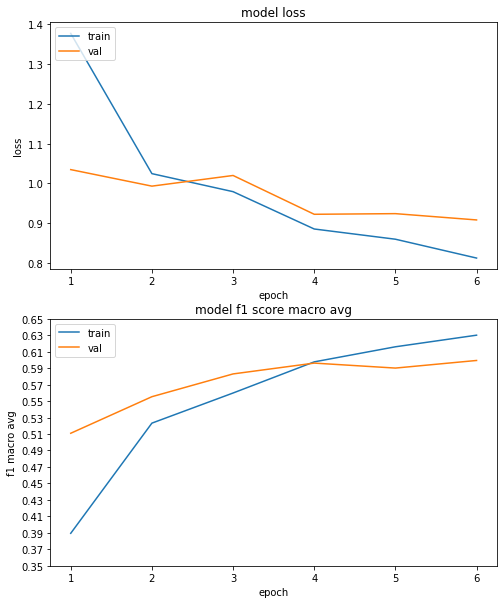

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 10))

x_len = np.arange(1, len(history.history['f1_score'])+ 1)

axs[0].plot(x_len, history.history['loss'])
axs[0].plot(x_len, history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')
axs[0].set_xticks(x_len)

axs[1].plot(x_len, history.history['f1_score'])
axs[1].plot(x_len, history.history['val_f1_score'])
axs[1].set_title('model f1 score macro avg')
axs[1].set_ylabel('f1 macro avg')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')
axs[1].set_xticks(x_len)
axs[1].set_yticks(np.arange(0.35, 0.65, step=0.02))

fig.show()